In [1]:
from skimage.io import imread
from skimage.transform import rotate
from numba import jit # conversion to machine code
import numpy as np
import matplotlib.pyplot as plt

## Functions
### a function to show multiple images

In [2]:
# a function to show multiple images
def show_images(**args):
    for i in args.keys():
        img=args[i]
        plt.figure(figsize=(10,10))
        d=len(img.shape)
        if d==2:
            plt.imshow(img,cmap='gray')
        else:
            plt.imshow(img)
        # plt.axis('off')
        plt.title(f'{i}')
        plt.show()

### generate Gaussian kernel, padding, and convolution
ref:  
exercise 2 @ https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm

In [3]:
def get_gaussian_kernel(sigma, size=0):
    if size == 0: # sizes are determined so that the kernel edges correspond to 5% of the peak value. 
        size = int(1 + 2 * np.ceil(sigma * np.sqrt(np.log(400))))
    mid = size // 2
    kernel = np.zeros((size, 1))
    dkernel = np.zeros((size, 1))
    for i in range(size):
        kernel[i] = np.exp(-((i - mid) / sigma) ** 2 / 2)
        dkernel[i] = -(i - mid) / (np.sqrt(2 * np.pi) * sigma ** 3) * kernel[i]
    kernel = kernel / kernel.sum()
    return kernel, dkernel


def padding_nearest(img, kernel):
    h, w = img.shape[:2]
    dim = len(img.shape)
    hk, wk = kernel.shape[:2]
    mid_hk, mid_wk = hk // 2, wk // 2
    if dim == 3:
        padded = np.zeros((h + hk - 1, w + wk - 1, 3))
    else:
        padded = np.zeros((h + hk - 1, w + wk - 1))
    padded[:mid_hk, mid_wk:w + mid_wk] = img[0:1, :]  # top
    padded[h + mid_hk:, mid_wk:w + mid_wk] = img[-1:, :]  # bottom
    padded[mid_hk:h + mid_hk, :mid_wk] = img[:, 0:1]  # left
    padded[mid_hk:h + mid_hk, w + mid_wk:] = img[:, -1:]  # right
    padded[:mid_hk, :mid_wk] = img[0, 0]  # top-left
    padded[:mid_hk, w + mid_wk:] = img[0, -1]  # top-right
    padded[h + mid_hk:, :mid_wk] = img[-1, 0]  # bottom-left
    padded[h + mid_hk:, w + mid_wk:] = img[-1, -1]  # bottom-right
    padded[mid_hk:h + mid_hk, mid_wk:w + mid_wk] = img
    return padded


def convolution(img, kernel):
    dim = len(img.shape)
    padded = padding_nearest(img, kernel)
    if dim == 3:
        kernel = np.repeat(kernel[:, :, np.newaxis], 3, axis=2)
    return convolution_numba(img, kernel, padded)


@jit(nopython=True, cache=True)
def convolution_numba(img, kernel, padded):
    h, w = img.shape[:2]
    hk, wk = kernel.shape[:2]
    output = np.zeros(img.shape)
    kernel = np.fliplr(np.flipud(kernel))  # flip upside-down and left-right
    for row in range(h):
        for col in range(w):
            output[row, col] = (padded[row:row + hk, col:col + wk] * kernel).sum(0).sum(0)
    return output

### reduce, expand, generate Gaussian pyramid, Laplacian pyramid, and collapse of the Laplacian pyramid

In [4]:
def reduce(img,sigma):
    kernel=get_gaussian_kernel(sigma=sigma)[0]
    return convolution(convolution(img,kernel)[::2,:],kernel.transpose())[:,::2]


def expand(img,img_up,sigma):
    kernel=2*get_gaussian_kernel(sigma=sigma)[0]
    output=np.zeros_like(img_up)
    output[::2,::2]=img
    return convolution(convolution(output,kernel),kernel.transpose())


def pyramid_gaussian(img,sigma,max_layer):
    pyramid=[img]
    for i in range(max_layer-1):
        downsampled=reduce(img,sigma)
        pyramid.append(downsampled)
        img=downsampled
    return np.array(pyramid,dtype=object)


def pyramid_laplacian(img,sigma,max_layer):
    pyramid=[]
    for i in range(max_layer-1):
        downsampled=reduce(img,sigma)
        upsampled=expand(downsampled,img,sigma)
        pyramid.append(img-upsampled)
        img=downsampled
    pyramid.append(img)
    return np.array(pyramid,dtype=object)


def collapse(pyramid,sigma):
    img=pyramid[-1]
    for i in reversed(range(len(pyramid)-1)):
        img=expand(img,pyramid[i],sigma)+pyramid[i]
    return img

## Blend apple and orange

In [5]:
%%time
sigma=1
max_layer=6

apple=imread('apple.png')/255
orange=imread('orange.png')/255
H,W,D=apple.shape

laplacian_pyramid_apple=pyramid_laplacian(apple,sigma,max_layer)
laplacian_pyramid_orange=pyramid_laplacian(orange,sigma,max_layer)

mask=np.zeros_like(apple,dtype=np.double)
mask[:,:W//2]=1

gaussian_pyramid_mask=pyramid_gaussian(mask,sigma,max_layer)

merged=collapse(laplacian_pyramid_apple*gaussian_pyramid_mask+laplacian_pyramid_orange*(1-gaussian_pyramid_mask),sigma)
merged[merged<0]=0
merged[merged>1]=1

CPU times: user 5.27 s, sys: 47.3 ms, total: 5.32 s
Wall time: 5.32 s


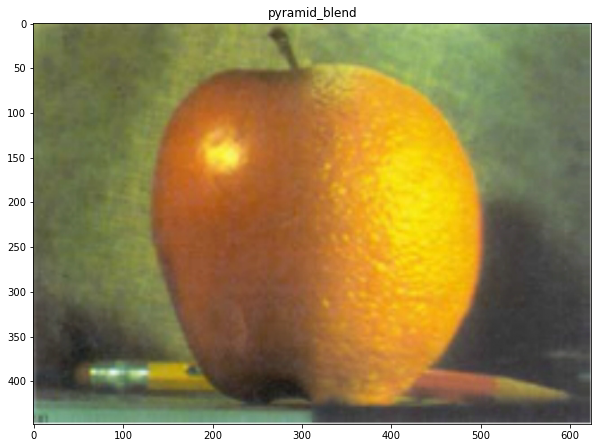

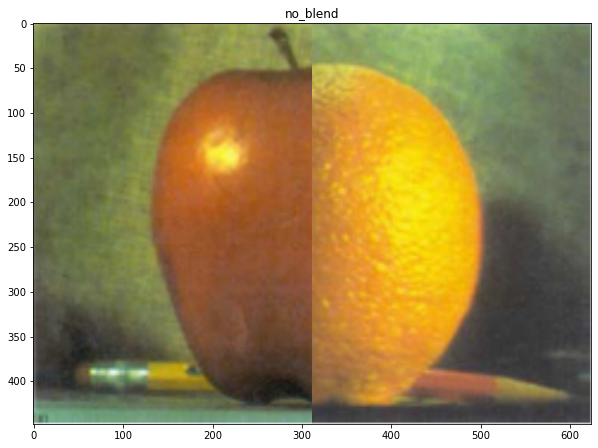

In [6]:
show_images(pyramid_blend=merged,no_blend=apple*mask+orange*(1-mask))

## face swap between a cheetah and a cat
### read images

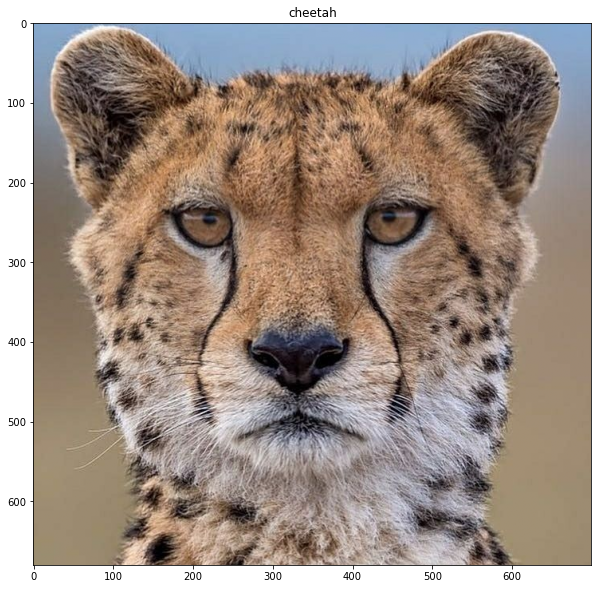

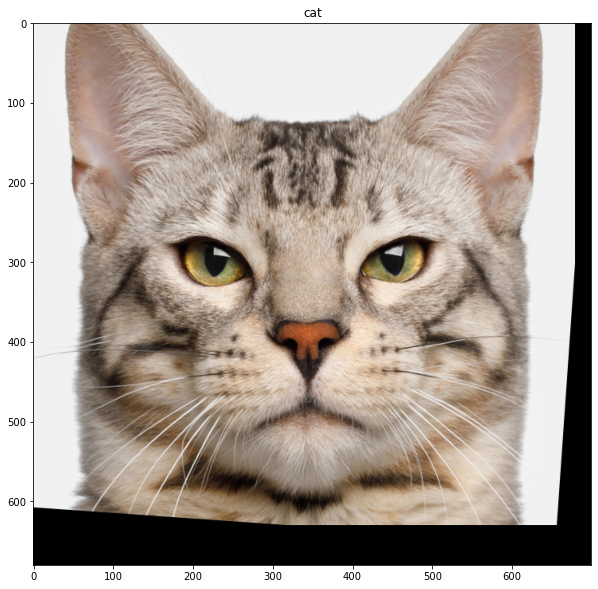

In [7]:
# face 1 is the cheetah face
face1=imread('face1.png')/255
H,W,D=face1.shape

# face 2 is the cat face, aligned using rotation and translation.
cat=rotate(imread('face2.png')/255,-4)
face2=np.zeros_like(cat)
face2[:H-50,:W-20]=cat[50:,20:]

show_images(cheetah=face1, cat=face2)

### face masks
ref:  
https://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array

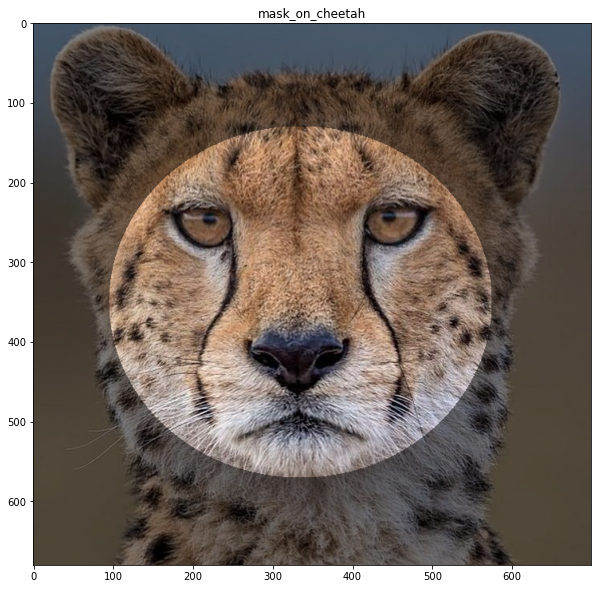

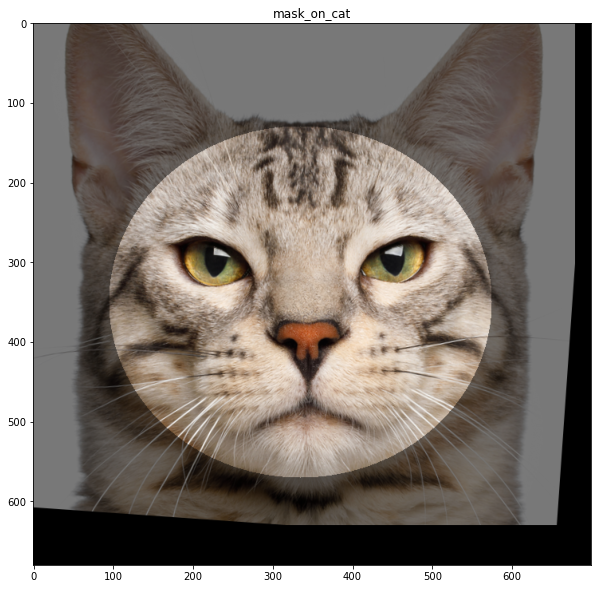

In [8]:
cy, cx = 350,335 # ellipse center
a=240 # major axis
b=220 # minor axis

y,x = np.ogrid[-cy:H-cy, -cx:W-cx]
criteria = b*b*x*x + a*a*y*y <= a*a*b*b

mask = np.zeros((H, W,3),dtype=np.double)
mask[criteria] = 1
mask[~criteria] = 0.5
show_images(mask_on_cheetah=face1*mask,mask_on_cat=face2*mask)

### cheetah face on cat head

In [9]:
%%time
sigma=1
max_layer=10
# create laplacian pyramids for cheetah and cat
laplacian_pyramid_cheetah=pyramid_laplacian(face1,sigma,max_layer)
laplacian_pyramid_cat=pyramid_laplacian(face2,sigma,max_layer)

# create mask
cy, cx = 350,335 # ellipse center
a=240 # major axis
b=220 # minor axis

y,x = np.ogrid[-cy:H-cy, -cx:W-cx]
criteria = b*b*x*x + a*a*y*y <= a*a*b*b

mask = np.zeros((H, W,3),dtype=np.double)
mask[criteria] = 1

# create gaussian pyramids of the mask
gaussian_pyramid_mask=pyramid_gaussian(mask,sigma,max_layer)

# merge laplacian pyramids with the mask, then collapse for the final merged image
merged=collapse(laplacian_pyramid_cheetah*gaussian_pyramid_mask+laplacian_pyramid_cat*(1-gaussian_pyramid_mask),sigma)
merged[merged<0]=0
merged[merged>1]=1

CPU times: user 8.79 s, sys: 56 ms, total: 8.85 s
Wall time: 8.84 s


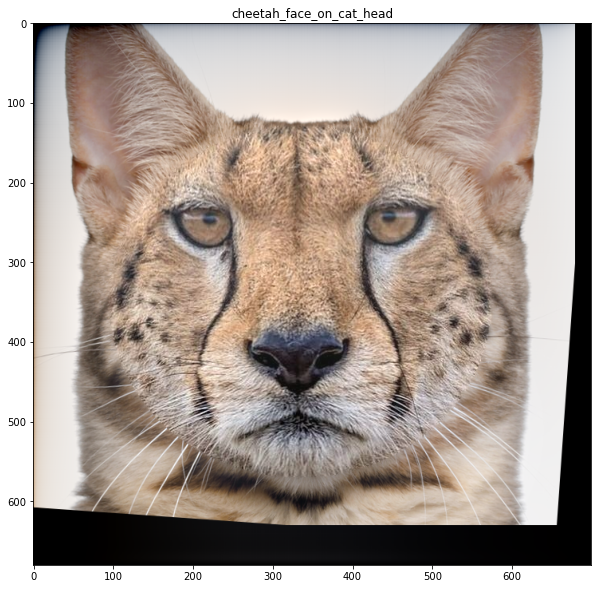

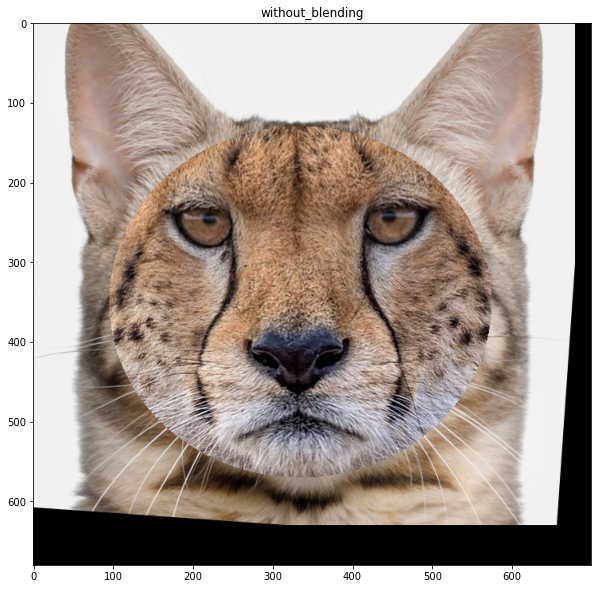

In [10]:
show_images(cheetah_face_on_cat_head=merged,without_blending=face1*mask+face2*(1-mask))

### cat face on cheetah head

In [11]:
%%time
mask = np.ones((H, W,3),dtype=np.double)
mask[criteria] = 0

gaussian_pyramid_mask=pyramid_gaussian(mask,sigma,max_layer)

merged=collapse(laplacian_pyramid_cheetah*gaussian_pyramid_mask+laplacian_pyramid_cat*(1-gaussian_pyramid_mask),sigma)
merged[merged<0]=0
merged[merged>1]=1

CPU times: user 3.03 s, sys: 23.9 ms, total: 3.06 s
Wall time: 3.05 s


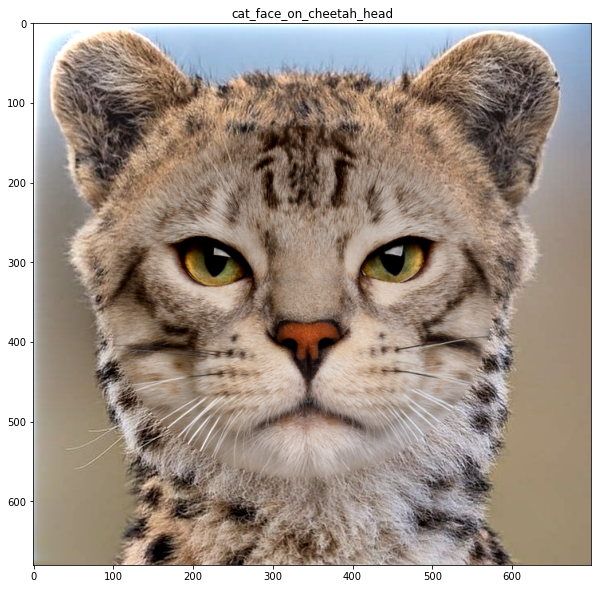

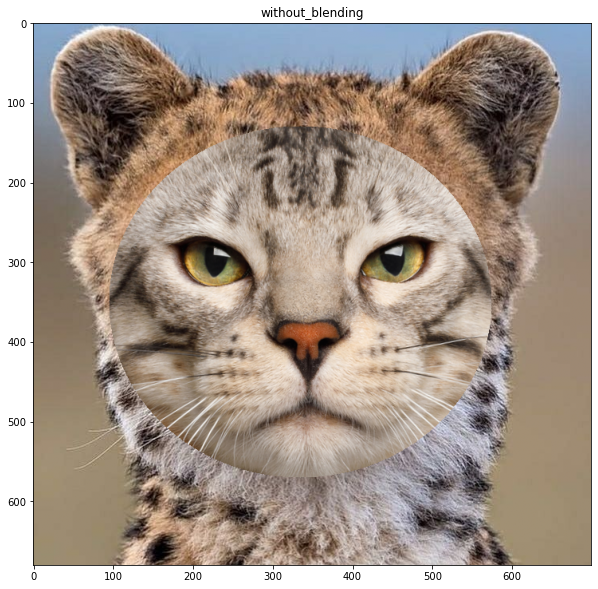

In [12]:
show_images(cat_face_on_cheetah_head=merged,without_blending=face1*mask+face2*(1-mask))